# Hyperparams

In [22]:
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


In [23]:
import time
import os
start_time = time.time()
import torch
from torch.utils.tensorboard import SummaryWriter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# wandb.init(project="BA-MAE", entity="alexandermittet")

########### PATHS ############
if os.name == 'posix': #mac
    fine_tune_path_imgs = '/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/img'
    pretrain_path_imgs = '/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/frames/class_0'
    pretrain_path =     '/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/frames'
    val_path_imgs =     "/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/validation_frames/class_0"
    val_path =          "/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/validation_frames"
elif os.name == 'nt': #windows
    fine_tune_path_imgs = 'C:\\Users\\alx\\Downloads\\img\\img'
    pretrain_path =     r'C:\Users\alx\Downloads\BA_data\frames'
    val_path =          r'C:\Users\alx\Downloads\BA_data\val_frames'

########### HYPER PARAMETERS ############
### MODEL SIZE
emb_dims =          192#192 #skal ku duvuderes med num_heads som er 4 
                    #85M params i TIMM classifiers, så den har vi smags til at 190*4 passer med 12 layers
encoder_layers =    12#12 i timm

### Pretraining
num_epochs =        50
dim =               224
mask_ratio =        0.75

training =          False #Pre-training MAE
load_prev_model =       True and training == False #MAE load
mae_to_load =           'mae_best.pth'
load_prev_model_dir =   f"C:\\Users\\alx\Downloads\\mdl_ckpt\\mae_m-{mask_ratio}" #MAE load
load_prev_model_path = os.path.join(load_prev_model_dir, mae_to_load)


### Global hyper params
custom_opt =            "prodigy" #bliver også brugt til fine tuning
learn_rate =            0.001
MAE_batch_size =        512
mes_batch_size =        32



three_shot =            True # 3-shot mes runs w/plots

if not three_shot:
    model_used =        "last" #mes model
    load_prev_fine_model_path   = f'C:\\Users\\alx\\Downloads\\mdl_ckpt\\mes_m-0.5\\mes_{model_used}.pth' # Mes load everytime if single run
load_fine_tuned =       False or three_shot #meS vi bliver nødt til, for at evaluere MES best.pth (og ikke last, som vi stadig ligger i memory)



### Fine-tuning
fine_tuning =       False or three_shot #MES training
num_fine_epochs =   20 #overfitter efter færre faktisk, men vi gemmer også best
fine_tune_eval =    False or three_shot


### T-sne feature plotting
tsne_plotting =     False
# tsne_target =       "all mes" #mes: "all mes", "mes1to3" #MAE:"validation images" "training images"
plot_single_image = False
plot_16_images =    False or load_prev_model

### Misc
get_num_params =    False
break_after_num_steps = -1
use_class4 =        False

run_name =          f"decontam-data_opt_{custom_opt}_max-e-{num_epochs}_m-{mask_ratio}_fine-e-{num_fine_epochs}_MAE_mes-bs-{MAE_batch_size}_{mes_batch_size}_emb_dim-{emb_dims}" #hyperparam string

## Dataset

In [24]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
#import torch.optim as optim #bruger prodigy
from torch.utils.data import DataLoader
import numpy as np
from prodigyopt import Prodigy
from torch.optim import AdamW
import lightning as L
# import wandb

from einops import repeat, rearrange
from einops.layers.torch import Rearrange

from timm.models.layers import trunc_normal_
from timm.models.vision_transformer import Block
from tqdm import tqdm

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((dim, dim)), # Resize the image to #32x32
    transforms.ToTensor(), # Convert the image to a PyTorch tensor
])

#dataset = CustomFramesDataset(root_dir=frames_path, transform=transform)
dataset = ImageFolder(
        pretrain_path,
        transform=transform,
    )

val_dataset = ImageFolder(
        val_path,
        transform=transform,
    ) 

# model architecture + masking fn

In [25]:
## ViT Model + functions
class MAE_Encoder(torch.nn.Module):
    def __init__(self,
                 image_size=dim,
                 patch_size=16,
                 emb_dim=emb_dims,
                 num_layer=encoder_layers,
                 num_head=4,
                 mask_ratio=mask_ratio,
                 ) -> None:
        super().__init__()

        self.cls_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2, 1, emb_dim))
        self.shuffle = PatchShuffle(mask_ratio)

        self.patchify = torch.nn.Conv2d(3, emb_dim, patch_size, patch_size)

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.layer_norm = torch.nn.LayerNorm(emb_dim)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.cls_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        
        # Calculate the number of patches
        num_patches = patches.shape[0]
        

        
        patches = patches + self.pos_embedding

        patches, forward_indexes, backward_indexes = self.shuffle(patches)

        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')

        return features, backward_indexes

class MAE_Decoder(torch.nn.Module):
    def __init__(self,
                 image_size=dim,
                 patch_size=16,
                 emb_dim=192,
                 num_layer=4,
                 num_head=3,
                 ) -> None:
        super().__init__()

        self.mask_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2 + 1, 1, emb_dim))

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.head = torch.nn.Linear(emb_dim, 3 * patch_size ** 2)
        self.patch2img = Rearrange('(h w) b (c p1 p2) -> b c (h p1) (w p2)', p1=patch_size, p2=patch_size, h=image_size//patch_size)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.mask_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, features, backward_indexes):
        T = features.shape[0]
        backward_indexes = torch.cat([torch.zeros(1, backward_indexes.shape[1]).to(backward_indexes), backward_indexes + 1], dim=0)
        features = torch.cat([features, self.mask_token.expand(backward_indexes.shape[0] - features.shape[0], features.shape[1], -1)], dim=0)
        features = take_indexes(features, backward_indexes)
        features = features + self.pos_embedding

        features = rearrange(features, 't b c -> b t c')
        features = self.transformer(features)
        features = rearrange(features, 'b t c -> t b c')
        features = features[1:] # remove global feature

        patches = self.head(features)
        mask = torch.zeros_like(patches)
        mask[T-1:] = 1
        mask = take_indexes(mask, backward_indexes[1:] - 1)
        img = self.patch2img(patches)
        mask = self.patch2img(mask)

        return img, mask

class MAE_ViT(torch.nn.Module):
    def __init__(self,
                 image_size=dim,
                 patch_size=16,
                 emb_dim=emb_dims,#192,
                 encoder_layer=encoder_layers,#12,
                 encoder_head=4,
                 decoder_layer=4,
                 decoder_head=4,
                 mask_ratio=mask_ratio,
                 ) -> None:
        super().__init__()

        self.encoder = MAE_Encoder(image_size, patch_size, emb_dim, encoder_layer, encoder_head, mask_ratio)
        self.decoder = MAE_Decoder(image_size, patch_size, emb_dim, decoder_layer, decoder_head)

    def forward(self, img):
        features, backward_indexes = self.encoder(img)
        predicted_img, mask = self.decoder(features,  backward_indexes)
        return predicted_img, mask

class ViT_Classifier(torch.nn.Module):
    def __init__(self, encoder : MAE_Encoder, num_classes=4) -> None:
        super().__init__()
        self.cls_token = encoder.cls_token
        self.pos_embedding = encoder.pos_embedding
        self.patchify = encoder.patchify
        self.transformer = encoder.transformer
        self.layer_norm = encoder.layer_norm
        self.head = torch.nn.Linear(self.pos_embedding.shape[-1], num_classes)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding
        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')
        logits = self.head(features[0])
        return logits
    

class PatchShuffle(torch.nn.Module):
    def __init__(self, ratio) -> None:
        super().__init__()
        self.ratio = ratio

    def forward(self, patches : torch.Tensor):
        T, B, C = patches.shape
        remain_T = int(T * (1 - self.ratio))

        indexes = [random_indexes(T) for _ in range(B)]
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)

        patches = take_indexes(patches, forward_indexes)
        patches = patches[:remain_T]

        return patches, forward_indexes, backward_indexes
    
def random_indexes(size : int):
    forward_indexes = np.arange(size)
    np.random.shuffle(forward_indexes)
    backward_indexes = np.argsort(forward_indexes)
    return forward_indexes, backward_indexes

def take_indexes(sequences, indexes):
    return torch.gather(sequences, 0, repeat(indexes, 't b -> t b c', c=sequences.shape[-1]))

def mask_image(image, mask_size):
    mask = torch.ones_like(image)
    mask[:, :mask_size, :mask_size] = 0
    return image * mask

# load  pre-train model if it exists

In [26]:
def load_model():
    import torch
    import os

    if os.path.exists(load_prev_model_path):
        # Load the checkpoint
        checkpoint = torch.load(load_prev_model_path)
        
        # Load the model state dict
        model = MAE_ViT().to(device)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Load the optimizer state dict
        if custom_opt == "prodigy":
            optimizer = Prodigy(model.parameters())
        elif custom_opt == "adamW":
            optimizer = AdamW(model.parameters(), lr=learn_rate)
        try: #try to load the state dict
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        except Exception:
            pass
        
        # Load the loss
        loss = checkpoint['loss']
        
        print(f"Model loaded with loss: {loss}")
    else:
        model = MAE_ViT().to(device)
        print("Model checkpoint not found. Init model from scratch.")
    return model, optimizer, loss

if load_prev_model:
    model, optimizer, loss = load_model()
else:
    model = MAE_ViT().to(device)
    if custom_opt == "adamW":
        learning_rate = learn_rate # Example learning rate
        optimizer = AdamW(model.parameters(), lr=learning_rate)
    elif custom_opt == "prodigy":
        optimizer = Prodigy(model.parameters())
    #loss er custom mse loss

Model loaded with loss: 0.0026793889701366425


# Num_params in MAE model

In [27]:
if get_num_params or plot_16_images:
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params:,.0f}")

Total number of parameters: 7,480,704


# Pre-Train model:

In [28]:
from torchsampler import ImbalancedDatasetSampler
dataloader = DataLoader(dataset, batch_size=MAE_batch_size, sampler=ImbalancedDatasetSampler(dataset)) #sampler=cycle_sampler
val_loader = DataLoader(val_dataset, batch_size=MAE_batch_size, sampler=ImbalancedDatasetSampler(val_dataset))
   
if training:    #Tensorboard writer
    
    import random
    from datetime import datetime
    now = datetime.now()
    # Format the datetime string to exclude the year
    formatted_datetime = now.strftime("%m-%d_%H-%M")
    # Use the formatted datetime in the path
    writer = SummaryWriter(os.path.join("logs", "mae", f"{formatted_datetime}_{run_name}"))

    #criterion = torch.nn.MSELoss() #pas
    val_iterator = iter(val_loader)

    best_val_loss = float('inf')
    step_count = 0
    for epoch in range(num_epochs):
        model.train()
        losses = []
        pbar = tqdm(iter(dataloader))
        for img, label in pbar:
            step_count += 1
            img = img.to(device)
            predicted_img, mask = model(img)
            loss = (
                    torch.mean((predicted_img - img) ** 2 * mask) / mask_ratio
                )
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())

            pbar.set_postfix({'step loss': loss.item()}, refresh=False)
            writer.add_scalar("mae/step_train_loss", loss.item(), global_step=step_count)
            # wandb.log({"Train Loss step": loss})

            if break_after_num_steps > 0: #set to -1 to disable early breaking
                if step_count >= break_after_num_steps: #Save and quit
                    # torch.save({
                    #             'model_state_dict': model.state_dict(),
                    #             'optimizer_state_dict': optimizer.state_dict(),
                    #             'loss': loss.item(),
                    #             }, './models/mae_checkpoint_break.pth')
                    break
        
        #For every epoch:
        avg_loss = sum(losses) / len(losses)
        writer.add_scalar("mae/epoch_train_loss", avg_loss, global_step=step_count)
        print(f"####TRAIN#### epoch {epoch}/{num_epochs}, avg train loss: {avg_loss:.4f}")
        # wandb.log({"Train Loss epoch avg": avg_loss})

        """ visualize the first 16 predicted images on val dataset"""
        model.eval()
        val_losses = []
        val_bar = tqdm(iter(val_loader))
        with torch.no_grad():
            for img, label in val_bar:
                img = img.to(device)
                predicted_img, mask = model(img)
                val_loss = (
                        torch.mean((predicted_img - img) ** 2 * mask) / mask_ratio
                    )
                val_losses.append(val_loss.item())
                #break #vi vil gerne køre alt validatio igennem
            
            avg_val_loss = torch.mean(torch.tensor(val_losses))
            writer.add_scalar("mae/epoch_val_loss", avg_val_loss.item(), global_step=step_count)

            

        ### Saving
        if val_loss < best_val_loss:
            improved = True
            # Update the best loss
            best_val_loss = val_loss
            
            # Construct the filename with the current loss included
            filename = f"mae_best.pth"
        else:
            improved = False
            filename = "mae_last.pth"
        # Construct the full path using os.path.join
        base_path = f"C:\\Users\\alx\\Downloads\\mdl_ckpt\\mae_m-{mask_ratio}"
        full_path = os.path.join(base_path, filename)
        shortened_path = os.path.join(f"mdl_ckpt\\mae_m-{mask_ratio}", filename)
        
        # Save the model
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
        }, full_path)
        if improved:
            print(f"###IMPROVED VAL#### Save w/avg loss {avg_loss:.4f} at {shortened_path}")
        
        improved = False


# Eval 16 imgs

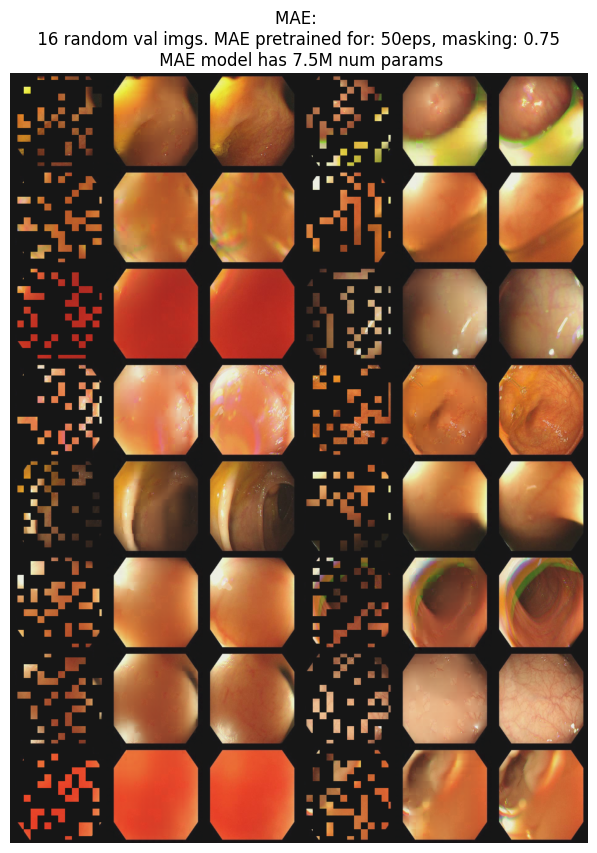

In [29]:
if plot_16_images:
    def plot_16_images():
        import matplotlib.pyplot as plt
        import random
        num_samples = 16
        indices = random.sample(range(len(val_dataset)), num_samples)
        val_samples = [val_dataset[i][0] for i in indices]
        val_img = torch.stack(val_samples)
        #val_img = torch.stack([val_dataset[i][0] for i in range(21)])
        

        val_img = val_img.to(device)
        predicted_val_img, mask = model(val_img)
        predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)
        img = torch.cat([val_img * (1 - mask), predicted_val_img, val_img], dim=0)
        img = rearrange(img, "(v h1 w1) c h w -> (h1 h) (w1 v w) c", w1=2, v=3)
        img_np = img.cpu().detach().numpy()
        min_val, max_val = np.min(img_np), np.max(img_np)
        range_val = max_val - min_val

        # Normalize the data
        normalized_img_np = (img_np - min_val) / range_val
        
        formatted_params = "{:,.1f}M".format(total_params / 1_000_000)
        plt.figure(figsize=(10, 10))
        plt.axis('off')
        plt.title(f'MAE: \n 16 random val imgs. MAE pretrained for: {num_epochs}eps, masking: {mask_ratio} \n MAE model has {formatted_params} num params')
        plt.imshow(normalized_img_np)
        plt.savefig(f"plots/mae_image_16x_m-{mask_ratio}_params-{formatted_params}.png", bbox_inches='tight')
        plt.show()
    
    plot_16_images()

# T-SNE current results

#### DO the work one time:

In [31]:
#if tsne_plotting or True:
# import pdb
if tsne_plotting:
    from torchvision import transforms
    from PIL import Image
    import numpy as np
    import os
    import torch
    from tqdm import tqdm 
    from sklearn.manifold import TSNE
    import pandas as pd
    import matplotlib.pyplot as plt

    def tsne_embeddings(input_paths: list, model) -> np.ndarray:
        encoder = model.encoder
        encoder = encoder.to(device)
        encoder.eval() # Set the model to evaluation mode
        
        transform = transforms.Compose([
            transforms.Resize((224, 224)), # Adjust size as needed
            transforms.ToTensor(),
        ])

        # Extract features
        features = []
        for path in tqdm(input_paths, desc="Processing images"): # Wrap image_paths with tqdm
            img = Image.open(path)
            img = transform(img).unsqueeze(0) # Add batch dimension
            img = img.to(device)
            with torch.no_grad():
                _, feature = encoder(img)
            features.append(feature.squeeze().cpu().numpy())
        # np.vstack enables parallel processing
        features = np.vstack(features)

        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42, n_jobs=-1, verbose=1) #12 it/s ved n_jobs=None
        embeddings = tsne.fit_transform(features)
        
        return embeddings


    df = pd.read_csv('img_labels_ALL.csv')
    image_paths = [os.path.join(fine_tune_path_imgs, img_name) for img_name in df['img']]
    #####TAKES TIME#######
    embeddings = tsne_embeddings(image_paths, model)



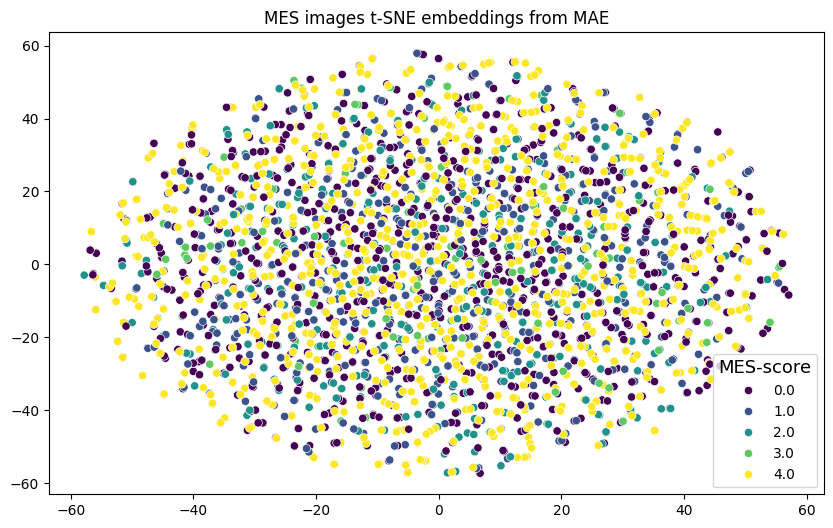

In [32]:
#PLOT w/class4
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], hue=df['score'], palette='viridis')
plt.title('MES images t-SNE embeddings from MAE')
plt.legend(title='MES-score', title_fontsize='13')
plt.savefig(f"plots/tsne/mes/t-sne_all_model-{model_used}.png")

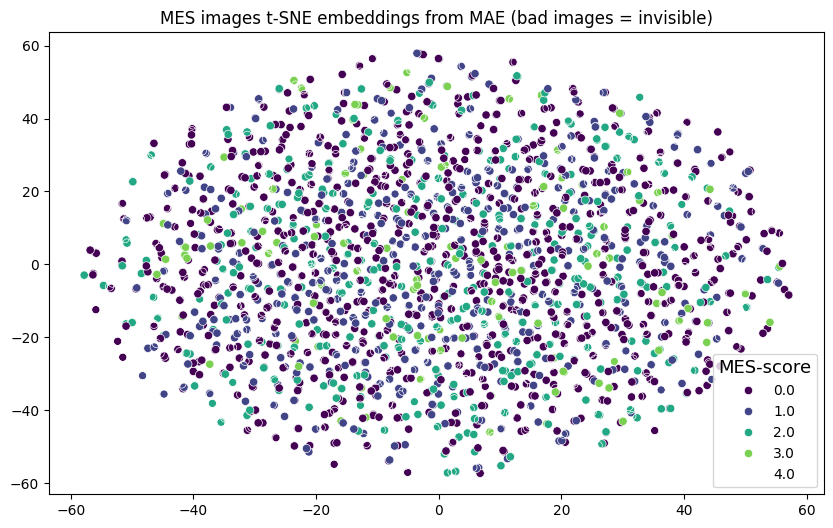

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
viridis = plt.get_cmap('viridis')
colors = ['purple', 'blue', 'green', 'yellow', 'yellow']
rgba_colors = [mcolors.to_rgba(viridis(i/len(colors))) for i in range(len(colors))]

custom_palette = sns.color_palette(rgba_colors)
custom_palette[2] = (0.134692, 0.658636, 0.517649, 1.0)
custom_palette[3] = (0.477504, 0.821444, 0.318195, 1.0) #god grøn
custom_palette[4] = (1, 1, 0, 0) #invis



plt.figure(figsize=(10, 6))
sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], hue=df['score'], palette=custom_palette)
plt.title('MES images t-SNE embeddings from MAE (bad images = invisible)')
plt.legend(title='MES-score', title_fontsize='13')
plt.savefig(f"plots/tsne/mes/t-sne_1to3_model-{model_used}.png")

# Fine tune model MES score 1x 

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torchsampler import ImbalancedDatasetSampler
encoder = model.encoder
classifier = ViT_Classifier(encoder, num_classes=4)
classifier.to(device)
criterion = torch.nn.CrossEntropyLoss()

#initialize new optimizers that arent biased from MAE training
if custom_opt == "prodigy":
    optimizer = Prodigy(classifier.parameters())
elif custom_opt == "adamW":
    optimizer = AdamW(classifier.parameters(), lr=learn_rate)

class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        img_path = f'{fine_tune_path_imgs}/{img_name}' ##### MAN KAN ÆNDRE PATH HER ift /class_0
        image = Image.open(img_path).convert('RGB')
        label = torch.tensor(self.df.iloc[idx, 2], dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, label
    def get_labels(self):
        label = torch.tensor(self.df.iloc[:, 2].tolist(), dtype=torch.long)
        return label
    
def init_dataloaders():
        #DATA LABELS
    df = pd.read_csv('img_labels_ALL.csv')

    # Remove class 4 (images lablelled as bad examples)
    if use_class4 == False:
        df = df[df['score'] != 4.0]
    #df.head() #Sanity check

    # Only use images that exist in the directory
    image_folder = fine_tune_path_imgs
    image_exists = df['img'].apply(lambda x: os.path.isfile(os.path.join(image_folder, x))) 
    filtered_df = df[image_exists]
    print(f"Original DataFrame size: {len(df)}, Filtered DataFrame size: {len(filtered_df)}") #Sanity check
    df = filtered_df

    # Stratify/balance classes across splits
    labels = df['score'].values
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=labels)
    train_labels = train_df['score'].values
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_labels)

    # Create data loaders for training and validation sets
    test_data = CustomDataset(test_df, transform)
    train_data = CustomDataset(train_df, transform)
    val_data = CustomDataset(val_df, transform)

    #More workers for GPU/lambda
    if torch.cuda.is_available():
        num_workers_local = 0
        test_loader = DataLoader(test_data, batch_size=mes_batch_size, num_workers=num_workers_local)
        train_loader = DataLoader(train_data, batch_size=mes_batch_size, sampler=ImbalancedDatasetSampler(train_data))#, num_workers=num_workers_local)
        val_loader = DataLoader(val_data, batch_size=mes_batch_size, num_workers=num_workers_local)
    else:
        test_loader = DataLoader(test_data, batch_size=mes_batch_size)
        train_loader = DataLoader(train_data, batch_size=mes_batch_size, sampler=ImbalancedDatasetSampler(train_data))
        val_loader = DataLoader(val_data, batch_size=mes_batch_size)
    return train_loader, val_loader, test_loader, test_data




def single_mes_run(iteration=None):
    if fine_tuning == True or three_shot:
        train_loader, val_loader, test_loader, test_data = init_dataloaders()
        #load the mae weights every run:
        model, optimizer, loss = load_model()


        encoder = model.encoder
        classifier = ViT_Classifier(encoder, num_classes=4)
        classifier.to(device)
        criterion = torch.nn.CrossEntropyLoss()

        from datetime import datetime
        now = datetime.now()

        # Format the datetime string to exclude the year
        formatted_datetime = now.strftime("%m-%d_%H-%M")
        # Use the formatted datetime in the path
        writer = SummaryWriter(os.path.join("logs", "MES", f"{formatted_datetime}_{run_name}_run{iteration}"))
    
        best_val_loss = float('inf')
        best_val_f1 = 0
        step_count = 0
        best_epoch_was = 0
        for epoch in range(num_fine_epochs): #training loop
            pbar = tqdm(iter(train_loader))
            classifier.train() # Set the model to training mode
            running_loss = 0.0
            for images, labels in pbar: #do one epoch
                # Move data to device
                images = images.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = classifier(images)
                
                # Compute loss
                loss = criterion(outputs, labels)
                pbar.set_postfix({'step loss': loss.item(), 'epoch': epoch}, refresh=False)
                writer.add_scalar('Fine_tune_loss/train-step', loss.item(), global_step=step_count)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                step_count += 1
                # Update running loss
                running_loss += loss.item() * images.size(0)
            
            #### EPOCH EVAL
            # Train loss 
            epoch_loss = running_loss / len(train_loader.dataset)
            writer.add_scalar('Fine_tune_loss/train-epoch', epoch_loss, global_step=step_count)
            
            # Val loss + f1
            classifier.eval() # Set the model to evaluation mode
            running_val_loss = 0.0
            running_f1_score = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = classifier(images)
                    val_loss = criterion(outputs, labels)
                    
                    # Calculate F1 score
                    labels_list = labels.cpu().numpy().tolist()
                    # Convert output scores to predicted class labels
                    predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy().tolist()
                    val_f1 = f1_score(labels_list, predicted_labels, average='weighted')

                    running_val_loss += val_loss.item() * images.size(0)
                    running_f1_score += val_f1 * images.size(0)
            
            val_epoch_loss = running_val_loss / len(val_loader.dataset)
            val_f1_score = running_f1_score / len(val_loader.dataset)
            writer.add_scalar('Fine_tune_loss/val-epoch_loss', val_epoch_loss, global_step=step_count)
            writer.add_scalar('Fine_tune_loss/val-epoch_f1', val_f1_score, global_step=step_count)

            #### SAVING
            #last
            torch.save({
                        'model_state_dict': classifier.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item(),
                        }, f'C:\\Users\\alx\\Downloads\\mdl_ckpt\\mes_m-{mask_ratio}\\mes_last.pth')
            
            #best val_loss
            if val_epoch_loss < best_val_loss:
                best_epoch_was = epoch
                best_val_loss = val_epoch_loss
                torch.save({
                        'model_state_dict': classifier.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item(),
                        'best_epoch_was': best_epoch_was,
                        }, f'C:\\Users\\alx\\Downloads\\mdl_ckpt\\mes_m-{mask_ratio}\\mes_best.pth')
            
            #best val_f1
            if val_f1_score > best_val_f1:
                best_f1_epoch_was = epoch
                best_val_f1 = val_f1_score
                torch.save({
                        'model_state_dict': classifier.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item(),
                        'best_epoch_was': best_f1_epoch_was,
                        }, f'C:\\Users\\alx\\Downloads\\mdl_ckpt\\mes_m-{mask_ratio}\\mes_best_f1.pth')


        print(f"Fine-tuning complete. Best epoch was {best_epoch_was}")
    return test_loader, test_data, now, best_epoch_was, best_f1_epoch_was

if three_shot == False and fine_tuning == True: #så må det jo være 1-shot
    test_loader, test_data, now, best_epoch_was, best_f1_epoch_was = single_mes_run()

# Load fine tuned:

In [35]:
if load_fine_tuned or three_shot:
    def load_fine_tuned_model(path):
        load_prev_fine_model_path = path
        import torch
        import os
        # try:
        #     step_count
        # except NameError:
        #     step_count = 190000 // batch_size * 64
        # Load the checkpoint
        checkpoint = torch.load(load_prev_fine_model_path)
        encoder = MAE_Encoder(image_size=dim, mask_ratio=mask_ratio, emb_dim=emb_dims) #xxx
        # Load the model state dict
        classifier = ViT_Classifier(encoder).to(device)#
        classifier.load_state_dict(checkpoint['model_state_dict'])
        
        # Load the optimizer state dict
        if custom_opt == "prodigy":
            optimizer = Prodigy(classifier.parameters())
        #optimizer.load_state_dict(checkpoint['optimizer_state_dict']) #do we need this?
        elif custom_opt == "adamW":
            optimizer = AdamW(classifier.parameters(), lr=learn_rate)
        # Load the loss
        loss = checkpoint['loss']
        try:
            best_epoch_was = checkpoint['best_epoch_was']
        except KeyError:
            best_epoch_was = num_fine_epochs
        
        
        print(f"Model loaded with loss: {loss}, where best/last epoch was {best_epoch_was}")
        return classifier, optimizer, loss, best_epoch_was
    
if not three_shot and load_fine_tuned:
    classifier, optimizer, loss, best_epoch_was = load_fine_tuned_model(load_prev_fine_model_path)


# Eval fine tuned calc

In [36]:
if fine_tune_eval == True or three_shot:    
    def calculate_evaluation_metrics(classifier, test_data):
        # from sklearn.metrics import classification_report
        # from concurrent.futures import ThreadPoolExecutor
        from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score


        from tqdm import tqdm
        import seaborn as sns
        import matplotlib.pyplot as plt

        def evaluate_single_sample(i):
            # Get the sample from the dataset
            sample, true_label = test_data[i]
            
            # Move the sample to the same device as the model
            sample = sample.to(device)
            
            # Pass the sample through the model
            with torch.no_grad():
                prediction = classifier(sample.unsqueeze(0))  # Unsqueeze to add batch dimension

            class_probabilities = prediction[0]


            _, predicted_class = torch.max(class_probabilities, dim=0)

            # Move the predicted_class back to CPU for further operations
            predicted_class = predicted_class.to('cpu')
            

            
            # Return the true label and the predicted class
            return true_label.item(), predicted_class.item()

        # Ensure the model is in evaluation mode
        classifier.eval()

        # Shared lists to store true labels and predicted classes
        true_labels_list = []
        predicted_classes_list = []

        # Evaluate all samples sequentially
        for i in tqdm(range(len(test_data)), desc='Evaluating'):
            true_label, predicted_class = evaluate_single_sample(i)
            true_labels_list.append(true_label)
            predicted_classes_list.append(predicted_class)

        # Assuming `true_labels` and `predicted_labels` are already defined
        f1 = f1_score(true_labels_list, predicted_classes_list, average='weighted')
        accuracy = accuracy_score(true_labels_list, predicted_classes_list)
        precision = precision_score(true_labels_list, predicted_classes_list, average='weighted')
        recall = recall_score(true_labels_list, predicted_classes_list, average='weighted')
        cm = confusion_matrix(true_labels_list, predicted_classes_list)
    
        return f1, accuracy, precision, recall, cm

# f1, accuracy, precision, recall, cm = calculate_evaluation_metrics(classifier, test_data)

# Num params in clf

In [37]:
total_params = sum(p.numel() for p in classifier.parameters())
print(f"Total number of parameters: {total_params:,.0f}")

Total number of parameters: 5,518,084


# Eval fine tune plot

In [38]:
if fine_tune_eval == True or three_shot:
    def mes_run_eval_plot(f1, accuracy, precision, recall, cm, iteration, model_used, best_epoch_was, eval_plot_name):   
        import matplotlib.pyplot as plt
        import seaborn as sns
        def format_number(num):
            if num >= 1000000:
                return f"{num // 1000000}M"
            elif num >= 1000:
                return f"{num // 1000}K"
            else:
                return str(num)
        
        # Create a figure and a 2x1 grid of subplots
        fig, axs = plt.subplots(1, 2, figsize=(15, 7))

        # Confusion matrix subplot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[0])
        axs[0].set_title('Confusion Matrix')
        axs[0].set_xlabel('Predicted')
        axs[0].set_ylabel('True')

        # F1 Score, Precision, Recall, and Accuracy subplot
        num_train_samples = len(dataloader)*MAE_batch_size # MAE image count we are interested in here
        num_train_samples = format_number(num_train_samples)
        total_params = sum(p.numel() for p in classifier.parameters())
        axs[1].set_title(f'Last/best/best_f1: {model_used}, run {iteration + 1} \n optimizer = {custom_opt}, MES-bs: {mes_batch_size}, MAE-bs {MAE_batch_size} \n MAE pretrained on {num_train_samples} training images, for: {num_epochs}e, MES fine-tuned for: {num_fine_epochs}e, \n masking ratio: {mask_ratio}, model has {total_params:,.0f} num params. \n Best val loss was on epoch {best_epoch_was}')
        axs[1].text(0.5, 0.8, f'F1 Score: {f1:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=14)
        axs[1].text(0.5, 0.4, f'Precision: {precision:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=14)
        axs[1].text(0.5, 0.2, f'Recall: {recall:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=14)
        axs[1].text(0.5, 0.6, f'Accuracy: {accuracy:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=14)
        axs[1].axis('off')
        
        fig.suptitle(f'MES evaluation', fontsize=20)
        plt.tight_layout()
        plt.savefig(f'./plots/eval_plot-{eval_plot_name}.png')
        plt.show()

    # mes_run_eval_plot(f1, accuracy, precision, recall, cm)

# DO 3 MES runs

### RUN 2/3 ###
Original DataFrame size: 1738, Filtered DataFrame size: 1738
Model loaded with loss: 0.0026793889701366425


100%|██████████| 35/35 [00:50<00:00,  1.44s/it, step loss=1.29, epoch=19] 


Fine-tuning complete. Best epoch was 11
Model loaded with loss: 1.2871513366699219, where best/last epoch was 20


Evaluating: 100%|██████████| 348/348 [00:22<00:00, 15.16it/s]


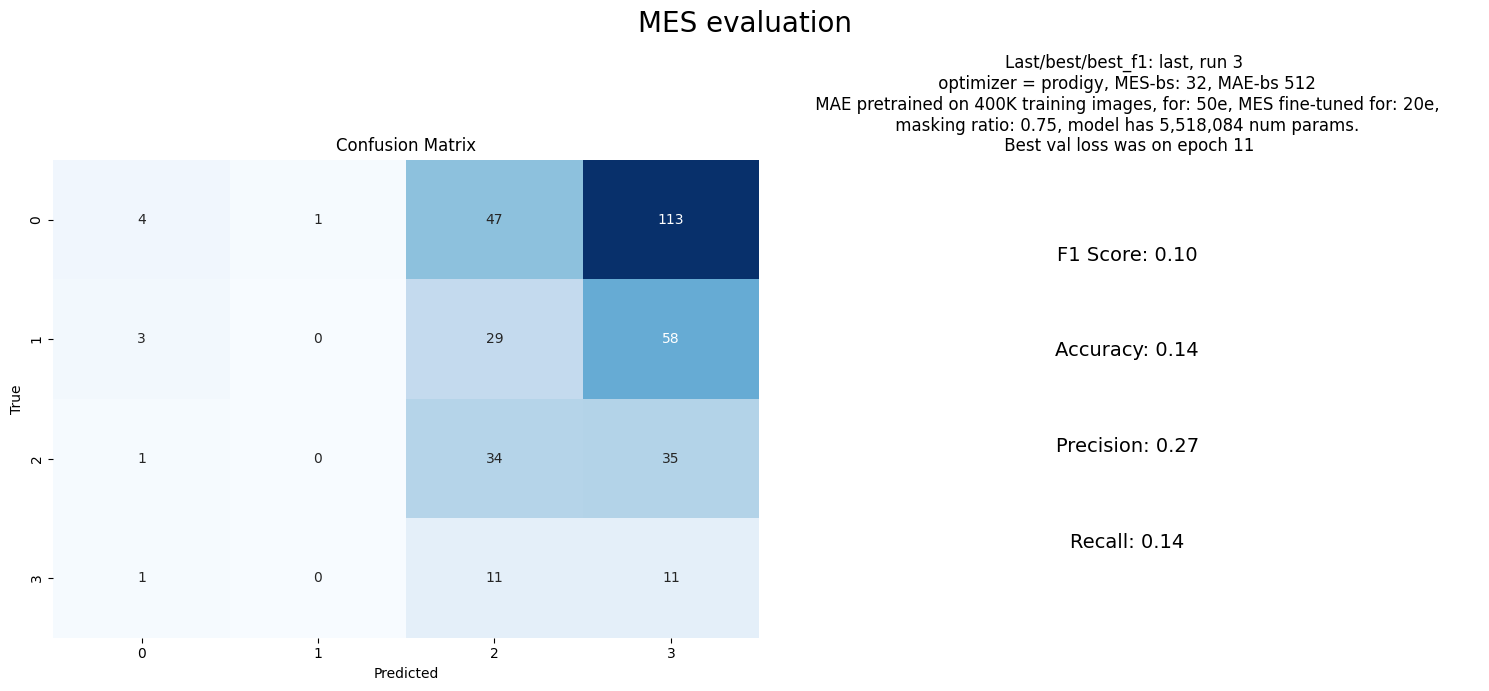

Model loaded with loss: 1.056015133857727, where best/last epoch was 11


Evaluating: 100%|██████████| 348/348 [00:22<00:00, 15.20it/s]


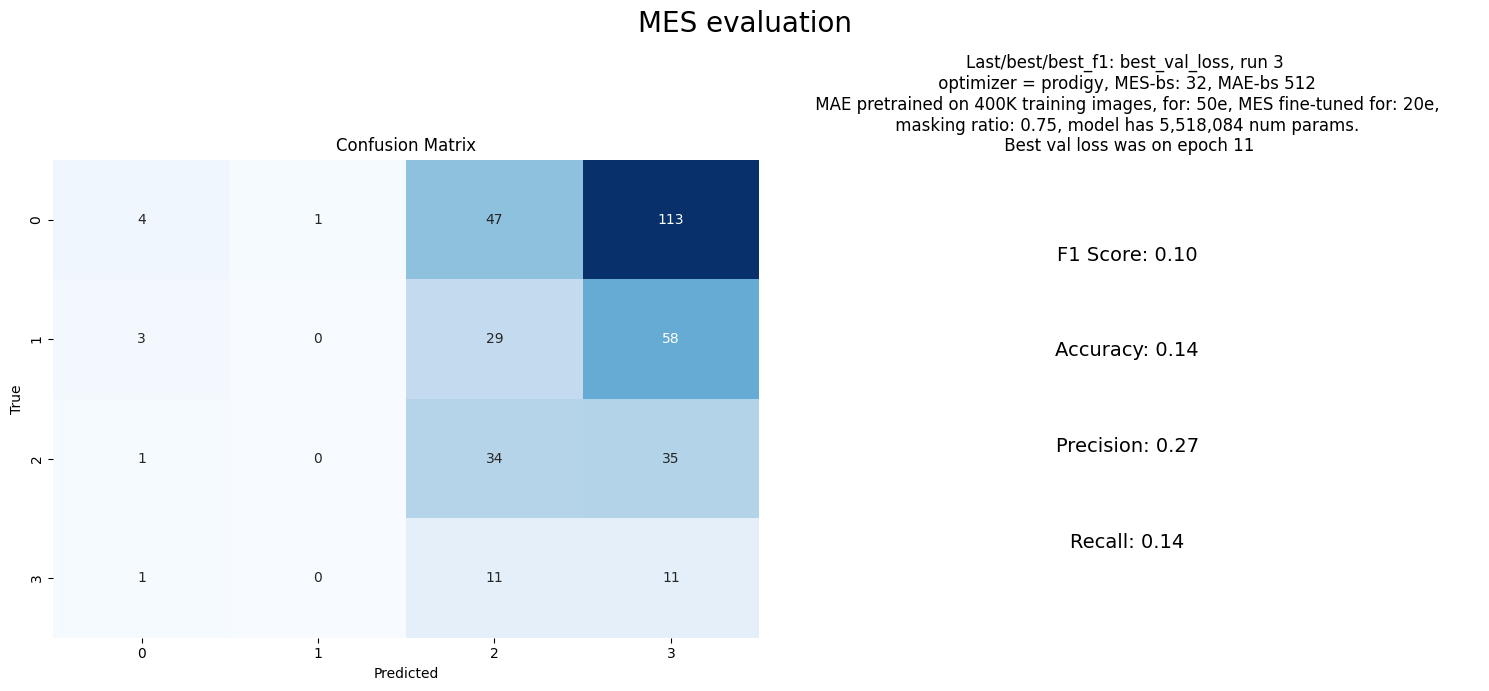

Model loaded with loss: 1.1527920961380005, where best/last epoch was 8


Evaluating: 100%|██████████| 348/348 [00:22<00:00, 15.21it/s]


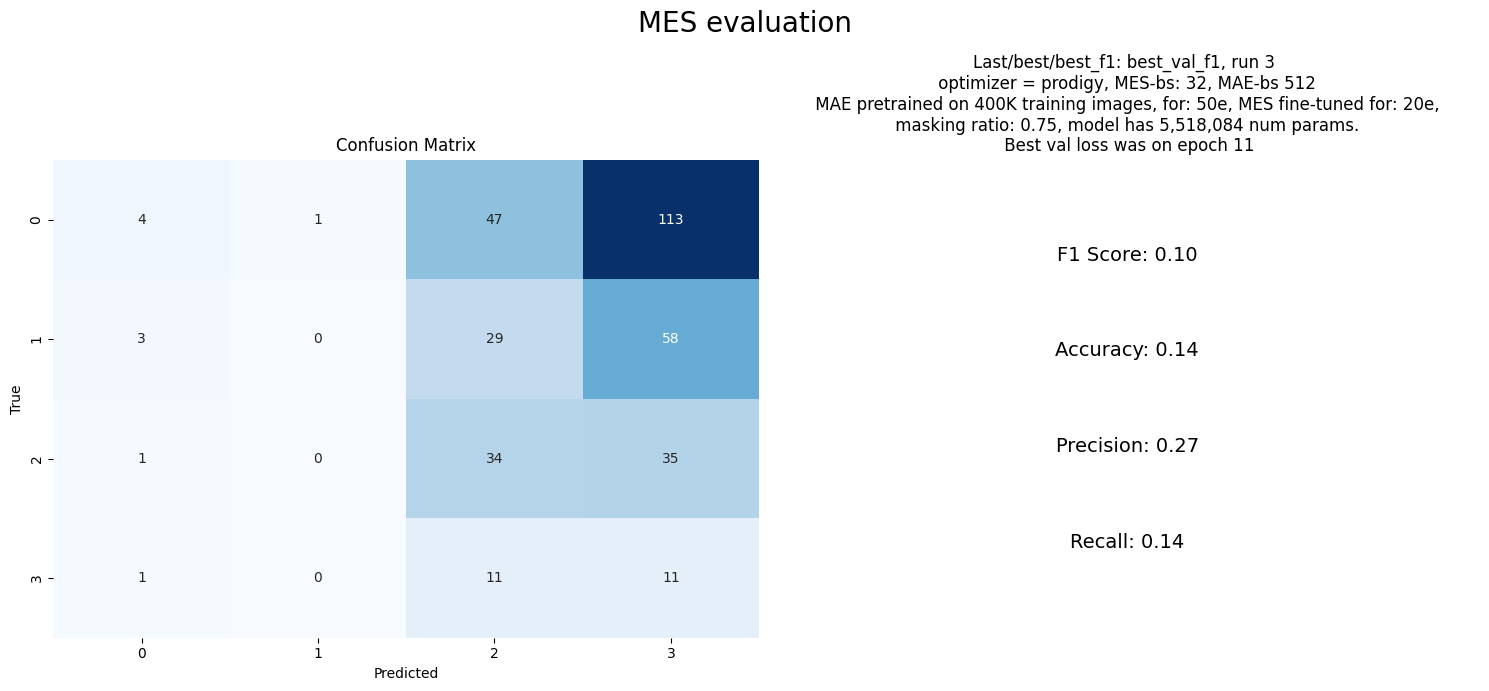

In [39]:
if three_shot:
    #load MAE 
    from sklearn.metrics import f1_score
    from IPython.display import clear_output
    mes_load_dir =  f'C:\\Users\\alx\\Downloads\\mdl_ckpt\mes_m-{mask_ratio}' #used for loading

    for i in range(1,4): #3 MES runs
        clear_output()
        print(f'### RUN {i}/3 ###')
        
        #run MES training:
        test_loader, test_data, now, best_epoch_was, best_f1_epoch_was = single_mes_run(i)

        # run eval on last model
        #load best.pth
        specific_model_path = 'mes_last.pth'
        specific_load_path = os.path.join(mes_load_dir, specific_model_path)
        load_fine_tuned_model(path=specific_load_path)
        model_used = 'last'
        eval_plot_name = f"MAE-370K_opt-{custom_opt}_max-e-{num_epochs}_MAE_mes-bs-{MAE_batch_size}_{mes_batch_size}_mask-{mask_ratio}_embdims-{emb_dims}_fine-e-{num_fine_epochs}_last_run{i}"
        f1, accuracy, precision, recall, cm = calculate_evaluation_metrics(classifier, test_data)
        mes_run_eval_plot(f1, accuracy, precision, recall, cm, i, model_used, best_epoch_was, eval_plot_name)

        # run eval on best  val loss model
        specific_model_path = 'mes_best.pth'
        specific_load_path = os.path.join(mes_load_dir, specific_model_path)
        load_fine_tuned_model(path=specific_load_path)
        model_used = 'best_val_loss'
        eval_plot_name = f"MAE-370K_opt-{custom_opt}_max-e-{num_epochs}_MAE_mes-bs-{MAE_batch_size}_{mes_batch_size}_mask-{mask_ratio}_embdims-{emb_dims}_fine-e-{num_fine_epochs}_best-valloss_run{i}"
        f1, accuracy, precision, recall, cm = calculate_evaluation_metrics(classifier, test_data)
        mes_run_eval_plot(f1, accuracy, precision, recall, cm, i, model_used, best_epoch_was, eval_plot_name)


        # run eval on best f1 score
        #load best_f1.pth
        specific_model_path = 'mes_best_f1.pth'
        specific_load_path_f1 = os.path.join(mes_load_dir, specific_model_path)
        load_fine_tuned_model(path=specific_load_path_f1)

        model_used = 'best_val_f1'
        eval_plot_name = f"MAE-370K_opt-{custom_opt}_max-e-{num_epochs}_MAE_mes-bs-{MAE_batch_size}_{mes_batch_size}_mask-{mask_ratio}_embdims-{emb_dims}_fine-e-{num_fine_epochs}_best-val-f1_run{i}"
        f1, accuracy, precision, recall, cm = calculate_evaluation_metrics(classifier, test_data)
        mes_run_eval_plot(f1, accuracy, precision, recall, cm, i, model_used, best_epoch_was, eval_plot_name)



In [40]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total runtime of this run: {total_time//60//60} hrs")

Total runtime of this run: 1.0 hrs


In [41]:
if os.name == 'nt':
    import winsound

    # Play a sound
    winsound.PlaySound("SystemExit", winsound.SND_ALIAS)
    winsound.PlaySound("SystemExit", winsound.SND_ALIAS)
    winsound.PlaySound("SystemExit", winsound.SND_ALIAS)
    winsound.PlaySound("SystemExit", winsound.SND_ALIAS)
    winsound.PlaySound("SystemExit", winsound.SND_ALIAS)